In [2]:
#@title matlab sovle image method
import numpy as np
from scipy.interpolate import interp1d

lookup_v = []
known_beta = []
xx = []
known_alpha = []

def solve_image(v, beta, alpha):
    """
    Solves the component-wise separable problem:
    min |w|^alpha + (beta/2) * (w - v)^2

    A LUT is used to solve the problem.
    """
    global lookup_v, known_beta, xx, known_alpha
    range_val = 10
    step = 0.0001

    if not known_beta or not known_alpha:
        xx = np.arange(-range_val, range_val + step, step)

    ind = [i for i, (b, a) in enumerate(zip(known_beta, known_alpha)) if b == beta and a == alpha]

    if ind:
        print(f'Reusing lookup table for beta {beta:.3g} and alpha {alpha:.3g}')
        f = interp1d(xx, lookup_v[ind[0], :], kind='linear', bounds_error=False, fill_value='extrapolate')
        w = f(v.flatten()).reshape(v.shape)

    else:
        tmp = compute_w(xx, beta, alpha)
        if len(lookup_v) == 0:
            lookup_v = np.array([tmp.flatten()])
        else:
            # Handle potential dimension mismatch by padding with zeros if needed.
            if tmp.shape[0] != lookup_v.shape[1]:
                max_len = max(tmp.shape[0], lookup_v.shape[1])
                if tmp.shape[0] < max_len:
                    pad_width = max_len - tmp.shape[0]
                    tmp = np.pad(tmp, (0, pad_width), 'constant')
                if lookup_v.shape[1] < max_len:
                  pad_width = max_len - lookup_v.shape[1]
                  lookup_v = np.pad(lookup_v, ((0,0),(0,pad_width)), 'constant')
            lookup_v = np.vstack([lookup_v, tmp.flatten()])

        known_beta.append(beta)
        known_alpha.append(alpha)

        f = interp1d(xx, lookup_v[-1, :], kind='linear', bounds_error=False, fill_value='extrapolate')
        w = f(v.flatten()).reshape(v.shape)

        print(f'Recomputing lookup table for new value of beta {beta:.3g} and alpha {alpha:.3g}')

    return w

def compute_w(v, beta, alpha):
    if abs(alpha - 1) < 1e-9:
        return compute_w1(v, beta)
    elif abs(alpha - 2/3) < 1e-9:
        return compute_w23(v, beta)
    elif abs(alpha - 1/2) < 1e-9:
        return compute_w12(v, beta)
    else:
        return newton_w(v, beta, alpha)

def compute_w23(v, beta):
    epsilon = 1e-6
    k = 8 / (27 * beta**3)
    m = np.ones_like(v) * k

    v2 = v * v
    v3 = v2 * v
    v4 = v3 * v
    m2 = m * m
    m3 = m2 * m

    alpha = -1.125 * v2
    beta2 = 0.25 * v3

    q = -0.125 * (m * v2)
    r1 = -q / 2 + np.sqrt(-m3 / 27 + (m2 * v4) / 256)

    u = np.exp(np.log(r1) / 3)
    y = 2 * (-5 / 18 * alpha + u + (m / (3 * u)))

    W = np.sqrt(alpha / 3 + y)

    root = np.zeros(v.shape + (4,), dtype=complex)
    root[..., 0] = 0.75 * v + 0.5 * (W + np.sqrt(-(alpha + y + beta2 / W)))
    root[..., 1] = 0.75 * v + 0.5 * (W - np.sqrt(-(alpha + y + beta2 / W)))
    root[..., 2] = 0.75 * v + 0.5 * (-W + np.sqrt(-(alpha + y - beta2 / W)))
    root[..., 3] = 0.75 * v + 0.5 * (-W - np.sqrt(-(alpha + y - beta2 / W)))

    v2 = np.repeat(v[..., np.newaxis], 4, axis=-1)
    sv2 = np.sign(v2)
    rsv2 = np.real(root) * sv2

    root_flag3 = np.sort(((np.abs(np.imag(root)) < epsilon) & (rsv2 > (np.abs(v2) / 2)) & (rsv2 < np.abs(v2))) * rsv2, axis=-1)[..., ::-1] * sv2
    w = root_flag3[..., 0]
    return w

def compute_w12(v, beta):
    epsilon = 1e-6
    k = -0.25 / beta**2
    m = np.ones_like(v) * k * np.sign(v)

    t1 = (2 / 3) * v
    v2 = v * v
    v3 = v2 * v

    #Using np.cbrt in place of exp(log())/3 to handle negative real numbers.
    t2 = np.cbrt(-27 * m - 2 * v3 + (3 * np.sqrt(3)) * np.sqrt(27 * m**2 + 4 * m * v3))
    t3 = v2 / t2

    root = np.zeros(v.shape + (3,), dtype=complex)
    root[..., 0] = t1 + (2**(1/3)) / 3 * t3 + (t2 / (3 * 2**(1/3)))
    root[..., 1] = t1 - ((1 + 1j * np.sqrt(3)) / (3 * 2**(2/3))) * t3 - ((1 - 1j * np.sqrt(3)) / (6 * 2**(1/3))) * t2
    root[..., 2] = t1 - ((1 - 1j * np.sqrt(3)) / (3 * 2**(2/3))) * t3 - ((1 + 1j * np.sqrt(3)) / (6 * 2**(1/3))) * t2

    root[np.isnan(root) | np.isinf(root)] = 0

    v2 = np.repeat(v[..., np.newaxis], 3, axis=-1)
    sv2 = np.sign(v2)
    rsv2 = np.real(root) * sv2

    root_flag3 = np.sort(((np.abs(np.imag(root)) < epsilon) & (rsv2 > (2 * np.abs(v2) / 3)) & (rsv2 < np.abs(v2))) * rsv2, axis=-1)[..., ::-1] * sv2
    w = root_flag3[..., 0]
    return w

def compute_w1(v, beta):
    return np.maximum(np.abs(v) - 1 / beta, 0) * np.sign(v)

def newton_w(v, beta, alpha):
    iterations = 4
    x = v

    for _ in range(iterations):
        fd = (alpha) * np.sign(x) * np.abs(x)**(alpha - 1) + beta * (x - v)
        fdd = alpha * (alpha - 1) * np.abs(x)**(alpha - 2) + beta
        x = x - fd / fdd

    x[np.isnan(x)] = 0

    z = beta / 2 * v**2
    f = np.abs(x)**alpha + beta / 2 * (x - v)**2
    w = (f < z) * x
    return w

In [3]:
#@title Fast Deconvoltion Main Algorithm
import numpy as np
from scipy.signal import convolve2d
from numpy.fft import fft2, ifft2, fftshift

def fast_deconv(yin, k, lambda_, alpha):
    """
    Fast deconvolution based on the algorithm described in the paper:
    "Fast Image Deconvolution using Hyper-Laplacian Priors" (NIPS 2009).
    Args:
        yin (np.ndarray): Observed blurry and noisy input grayscale image.
        k (np.ndarray): Convolution kernel.
        lambda_ (float): Parameter that balances likelihood and prior term weighting.
        alpha (float): Parameter between 0 and 2.
    Returns:
        np.ndarray: Deconvolved image.
    """
    # Continuation parameters
    beta = 1
    beta_rate = 2 * np.sqrt(2)
    beta_max = 2**6

    # Number of inner iterations per outer iteration
    mit_inn = 1

    m, n = yin.shape

    # Initialize with input
    yout = yin.copy()

    # Ensure kernel size is odd
    if k.shape[0] % 2 != 1 or k.shape[1] % 2 != 1:
        raise ValueError("Error - blur kernel k must be odd-sized.")

    # Compute x and y gradients of yout
    youtx = np.hstack((np.diff(yout, axis=1), yout[:, :1] - yout[:, -1:]))
    youty = np.vstack((np.diff(yout, axis=0), yout[:1, :] - yout[-1:, :]))

    # Main loop
    while beta < beta_max:
        gamma = lambda_ / beta
        for _ in range(mit_inn):
            # w-subproblem
            wx = solve_image(youtx, beta, alpha)
            wy = solve_image(youty, beta, alpha)
            # x-subproblem
            wxx = np.hstack((wx[:, -1:] - wx[:, :1], -np.diff(wx, axis=1)))
            wxx += np.vstack((wy[-1:, :] - wy[:1, :], -np.diff(wy, axis=0)))
            # compute Fs
            F1 = psf2otf(np.array([[1, -1]]), y.shape)
            F2 = psf2otf(np.array([[1], [-1]]), y.shape)
            # compute output
            fyout_num = np.conj(F1) * fft2(wx) + np.conj(F2) * fft2(wxx) + gamma * np.conj(psf2otf(k, y.shape)) * fft2(yin)
            fyout_den = np.conj(F1) * F1       + np.conj(F2) * F2        + gamma * np.conj(psf2otf(k, y.shape)) * psf2otf(k, y.shape)
            fyout = fyout_num / fyout_den
            yout = np.real(ifft2(fyout))

        beta *= beta_rate

    return yout

def psf2otf(psf, shape):
    """
    Converts a point spread function to an optical transfer function.
    Args:
        psf (np.ndarray): Point spread function.
        shape (tuple): Shape of the output array.
    Returns:
        np.ndarray: Optical transfer function.
    """
    # Calculate the amount of padding needed on each side
    pad_h = shape[0] - psf.shape[0]
    pad_w = shape[1] - psf.shape[1]

    # Pad the PSF, ensuring the origin is in the center
    padded_psf = np.pad(psf, ((pad_h // 2, (pad_h + 1) // 2), (pad_w // 2, (pad_w + 1) // 2)), mode='constant')

    # Now, fftshift to move the origin to the top-left corner for FFT
    shifted_psf = np.fft.fftshift(padded_psf)

    # Compute the FFT
    otf = fft2(shifted_psf)

    return otf

def solve_eqn_5(v, beta):
    """
    Solve a cubic equation for alpha = 1/2.

    Parameters:
        v (numpy.ndarray): Input array.
        beta (float): Scalar parameter.

    Returns:
        numpy.ndarray: Resulting array `w`.
    """
    epsilon = 1e-6  # Tolerance on imaginary part of the real root

    k = -0.25 / beta**2
    m = np.ones_like(v) * k * np.sign(v)

    # Compute the roots (all 3)
    t1 = (2 / 3) * v

    v2 = v**2
    v3 = v**3

    # Compute t2
    discriminant = 27 * m**2 + 4 * m * v3
    sqrt_discriminant = (3 * np.sqrt(3)) * np.sqrt(discriminant)
    log_term = np.log(-27 * m - 2 * v3 + sqrt_discriminant)
    t2 = np.exp(log_term / 3)

    t3 = v2 / t2

    # Compute all 3 roots
    root = np.zeros((*v.shape, 3), dtype=np.complex128)
    root[..., 0] = t1 + (2**(1/3)) / 3 * t3 + t2 / (3 * 2**(1/3))
    root[..., 1] = t1 - ((1 + 1j * np.sqrt(3)) / (3 * 2**(2/3))) * t3 - ((1 - 1j * np.sqrt(3)) / (6 * 2**(1/3))) * t2
    root[..., 2] = t1 - ((1 - 1j * np.sqrt(3)) / (3 * 2**(2/3))) * t3 - ((1 + 1j * np.sqrt(3)) / (6 * 2**(1/3))) * t2

    # Handle NaN and Inf cases
    root[np.isnan(root) | np.isinf(root)] = 0

    # Pick the right root
    v_repeated = np.repeat(v[..., np.newaxis], 3, axis=-1)
    sv2 = np.sign(v_repeated)
    rsv2 = np.real(root) * sv2

    condition = ((np.abs(np.imag(root)) < epsilon) &
                 (rsv2 > (2 * np.abs(v_repeated) / 3)) &
                 (rsv2 < np.abs(v_repeated)))

    root_flag3 = np.sort((condition * rsv2), axis=-1)[:, :, ::-1] * sv2
    w = root_flag3[..., 0]

    return w


In [4]:
#@title Edge Taper Method
import cv2
def edge_taper(image, taper_size):
    """Applies edge tapering to an image.

    Args:
        image (numpy.ndarray): The input image (grayscale).
        taper_size (int): The size of the taper region in pixels.

    Returns:
        numpy.ndarray: The edge-tapered image.
        Returns original image if taper_size is invalid.
    """
    if taper_size <= 0 or taper_size > min(image.shape)//2:
        print("Invalid taper size. Returning original image.")
        return image

    mask = np.ones_like(image, dtype=np.float32)

    # Corrected taper calculation: Create a gradient from 0 to 1
    x = np.linspace(0, 1, taper_size)

    # Apply the gradients to all four edges. Now it correctly tapers to 0 at the edges
    mask[:taper_size, :] *= x[:, np.newaxis]
    mask[-taper_size:, :] *= x[::-1, np.newaxis]
    mask[:, :taper_size] *= x
    mask[:, -taper_size:] *= x[::-1]

    tapered_image = image * mask
    return tapered_image

In [5]:
#@title Calculate SNR

def snr(original_img, modified_img):
    """
    Calculates the Signal-to-Noise Ratio (SNR) between an original and a modified image.

    Args:
        original_image_path: Path to the original (reference) image.
        modified_image_path: Path to the modified (e.g., blurred) image.

    Returns:
        A tuple containing:
            - SNR (ratio)
            - SNR (dB)
    """
    try:

        if original_img is None or modified_img is None:
            raise ValueError("Could not load one or both images. Please check the file paths.")

        # 2. Ensure Same Size (Not strictly necessary for this calculation, but good practice)
        if original_img.shape != modified_img.shape:
            raise ValueError("Images must have the same dimensions.")

        # 3. Calculate the Difference (Noise)
        noise = np.abs(original_img.astype(np.float64) - modified_img.astype(np.float64))

        # 4. Calculate Signal Power
        signal_power = np.mean(original_img.astype(np.float64)**2)

        # 5. Calculate Noise Power
        noise_power = np.mean(noise**2)
        print(f"{signal_power=}")
        print(f"{noise_power=}")

        # 6. Calculate SNR (Ratio)
        snr_ratio = signal_power / noise_power

        # 7. Calculate SNR (dB)
        snr_db = 10 * np.log10(snr_ratio)

        return snr_ratio # snr_ratio, snr_db

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

In [6]:
#@title Create blur kernel
def generate_gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    """
    Generates a 2D Gaussian kernel.

    Parameters:
        size (int): The size of the kernel (must be odd).
        sigma (float): The standard deviation of the Gaussian.

    Returns:
        np.ndarray: A 2D Gaussian kernel.
    """
    if size % 2 == 0:
        raise ValueError("Kernel size must be odd.")

    # Create a grid of (x, y) coordinates centered at zero
    radius = size // 2
    x = np.arange(-radius, radius + 1)
    y = np.arange(-radius, radius + 1)
    x, y = np.meshgrid(x, y)

    # Compute the Gaussian function
    gaussian = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    # Normalize the kernel so that the sum of all elements is 1
    kernel = gaussian / gaussian.sum()

    return kernel

In [7]:
#@title Fast Deconvolution Application
import numpy as np
from scipy.signal import convolve2d
from skimage.io import imread
import matplotlib.pyplot as plt
import scipy
from google.colab.patches import cv2_imshow
import cv2
from time import time
from skimage import color, data, restoration

# Parameters
lambda_ = 6e3
alpha = 1/2
IMG_SIZE = 1024

# Load and normalize input image
y = cv2.imread('dsc_0085.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float128)/255 # .astype(np.float64) / 255.0
_ref_save = y.copy()
# Load kernels
kernels = scipy.io.loadmat('kernels.mat')
kernel1 = kernels['kernel2']
kernel = generate_gaussian_kernel(21, 20) #kernel1
ks = (kernel.shape[0] - 1) // 2
# Crop image to predefined size
cy, cx = 1872, 1866
yorig = y[cy - IMG_SIZE // 2 - ks:cy + IMG_SIZE // 2 + ks, cx - IMG_SIZE // 2 - ks:cx + IMG_SIZE // 2 + ks]
y = y[cy - IMG_SIZE // 2:cy + IMG_SIZE // 2, cx - IMG_SIZE // 2:cx + IMG_SIZE // 2]
# taper the edge
y = edge_taper(y, 40)
# keep copy of the original
yorig = y.copy()
# Convolve with kernel
y = convolve2d(yorig, kernel, mode='valid')
# add noise
# y += 0.01 * np.random.randn(*y.shape)
# y = (y * 255).astype(np.uint8).astype(np.float128) / 255.0
# Apply padding
y = np.pad(y, [(ks, ks), (ks, ks)], mode='constant')
# timing
start_time = time()
# run fast deconvolution
x = fast_deconv(y, kernel, lambda_, alpha)
# capture time
time_taken = time() - start_time
# Compute SNR for reconstructed image
snr_recon = snr(yorig, x)
# Compute SNR for blurred image
snr_blur = snr(yorig, y)
# Remove padding
x = x[ks:-ks, ks:-ks]
y = y[ks:-ks, ks:-ks]
yorig = yorig[ks:-ks, ks:-ks]
# Display results
plt.figure()
plt.imshow(np.hstack((yorig, y, x)), cmap='gray')
print(f"{snr_recon=}")
print(f"{snr_blur=}")
title = f"Blurred (SNR {snr_blur:.2f}) Reconstructed (SNR {snr_recon:.2f})"
plt.title(title)
plt.axis('off')
plt.show()
cv2_imshow(yorig * 255)
cv2_imshow(y     * 255)
cv2_imshow(x     * 255)
cv2.imwrite("yorig.png", np.uint8(yorig * 255))
cv2.imwrite("y.png", np.uint8(y     * 255))
cv2.imwrite("x.png", np.uint8(x     * 255))
print(f"Time taken for image of size {IMG_SIZE}x{IMG_SIZE} is {time_taken:.3f} seconds.")


Output hidden; open in https://colab.research.google.com to view.

running RL
signal_power=0.2355888070771105
noise_power=0.009494043911415112
signal_power=0.2355888070771105
noise_power=0.010876787949357331
snr_recon=24.814379338803306
snr_blur=21.65977751648919


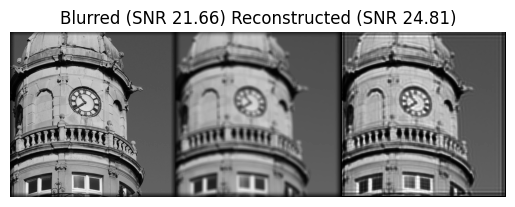

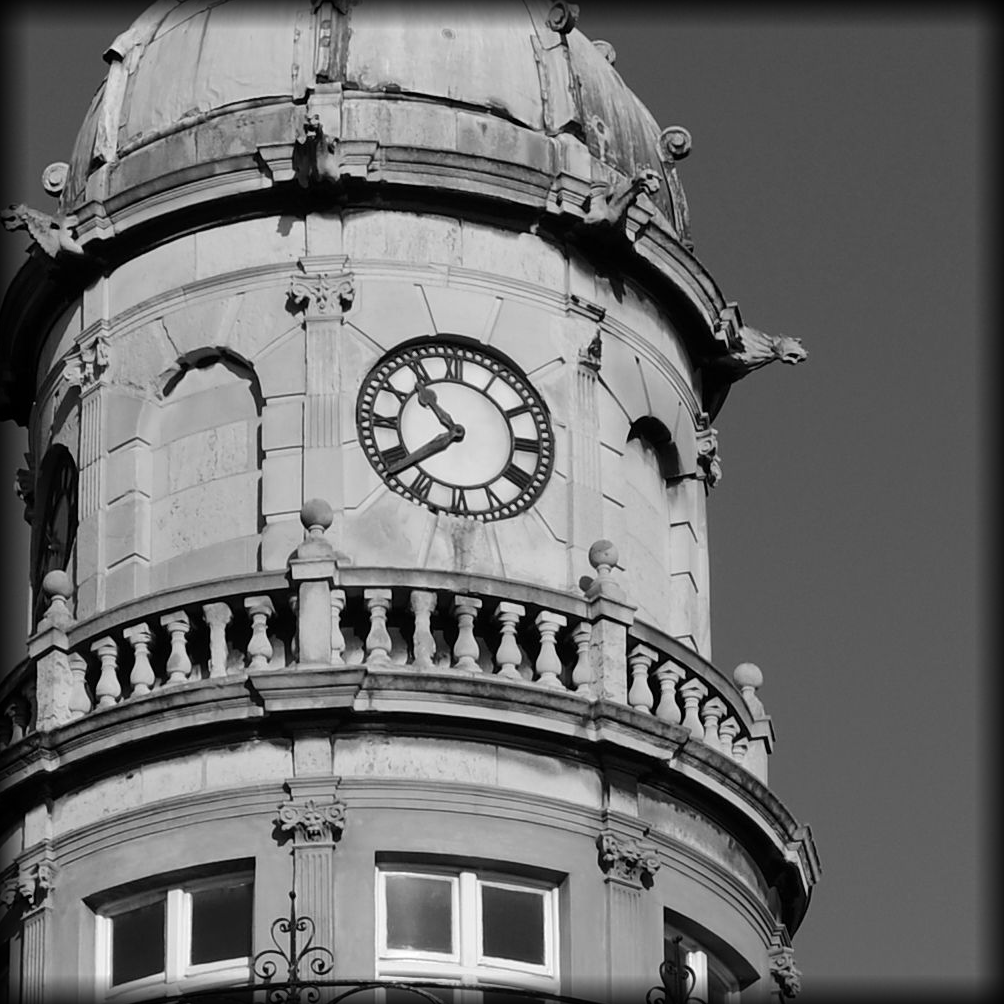

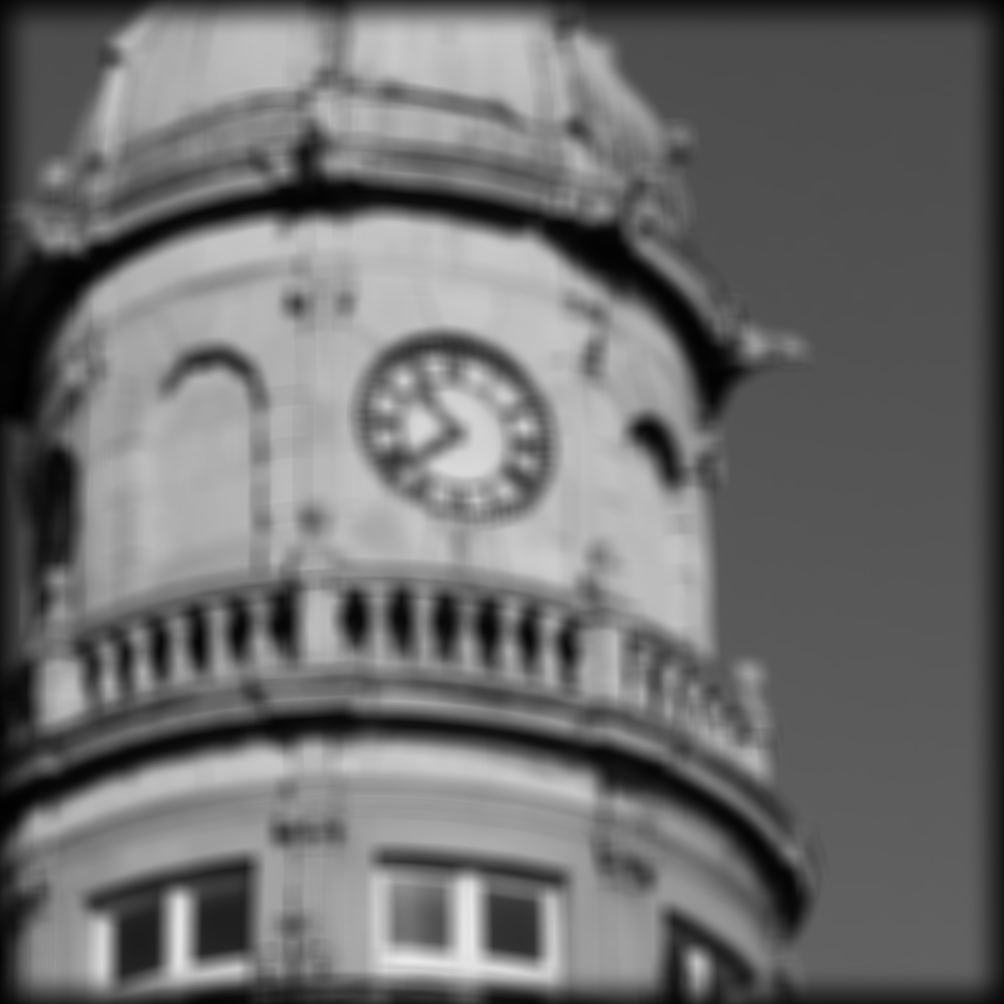

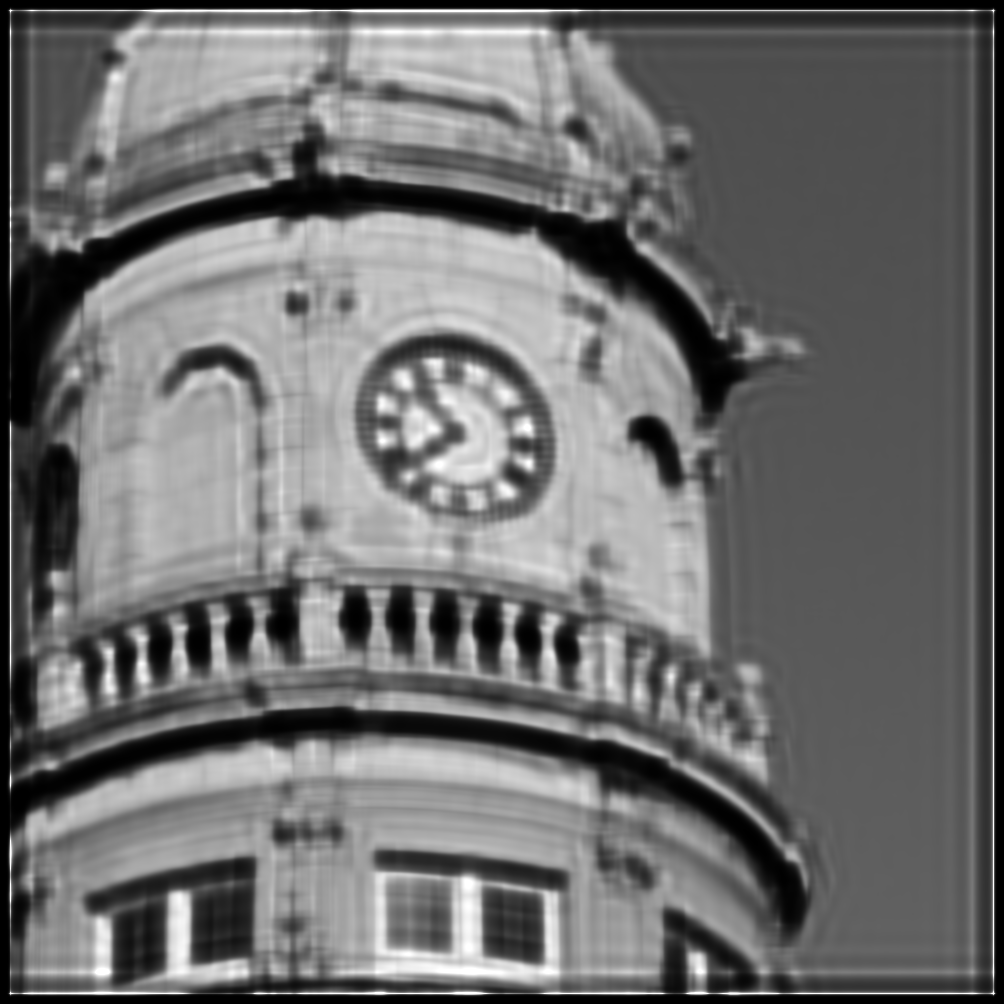

Time taken for image of size 1024x1024 is 4.971 seconds.


In [8]:
#@title Richardson Lucy Application
import numpy as np
from scipy.signal import convolve2d
from skimage.io import imread
import matplotlib.pyplot as plt
import scipy
from google.colab.patches import cv2_imshow
import cv2
from time import time
from skimage import color, data, restoration

# Load and normalize input image
y = cv2.imread('dsc_0085.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float128)/255 # .astype(np.float64) / 255.0
# Load kernels
kernels = scipy.io.loadmat('kernels.mat')
kernel1 = kernels['kernel2']
kernel = generate_gaussian_kernel(21, 20) #kernel1
ks = (kernel.shape[0] - 1) // 2
# Crop image to predefined size
cy, cx = 1872, 1866
yorig = y[cy - IMG_SIZE // 2 - ks:cy + IMG_SIZE // 2 + ks, cx - IMG_SIZE // 2 - ks:cx + IMG_SIZE // 2 + ks]
y = y[cy - IMG_SIZE // 2:cy + IMG_SIZE // 2, cx - IMG_SIZE // 2:cx + IMG_SIZE // 2]
# taper the edge
y = edge_taper(y, 40)
# keep copy of the original
yorig = y.copy()
# Convolve with kernel
y = convolve2d(yorig, kernel, mode='valid')
# add noise
# y += 0.01 * np.random.randn(*y.shape)
# y = (y * 255).astype(np.uint8).astype(np.float128) / 255.0
# Apply padding
y = np.pad(y, [(ks, ks), (ks, ks)], mode='constant')
# timing
start_time = time()
# run fast deconvolution
print("running RL")
x = restoration.richardson_lucy(y, kernel, num_iter=30) #fast_deconv(y, kernel, lambda_, alpha)
# capture time
time_taken = time() - start_time
# Compute SNR for reconstructed image
snr_recon = snr(yorig, x)
# Compute SNR for blurred image
snr_blur = snr(yorig, y)
# Remove padding
x = x[ks:-ks, ks:-ks]
y = y[ks:-ks, ks:-ks]
yorig = yorig[ks:-ks, ks:-ks]
# Display results
plt.figure()
plt.imshow(np.hstack((yorig, y, x)), cmap='gray')
print(f"{snr_recon=}")
print(f"{snr_blur=}")
title = f"Blurred (SNR {snr_blur:.2f}) Reconstructed (SNR {snr_recon:.2f})"
plt.title(title)
plt.axis('off')
plt.show()
cv2_imshow(yorig * 255)
cv2_imshow(y     * 255)
cv2_imshow(x     * 255)
cv2.imwrite("yorig.png", np.uint8(yorig * 255))
cv2.imwrite("y.png", np.uint8(y     * 255))
cv2.imwrite("x.png", np.uint8(x     * 255))
print(f"Time taken for image of size {IMG_SIZE}x{IMG_SIZE} is {time_taken:.3f} seconds.")
